## 2. Training set과 Test set 나누기

- github colab : https://homl.info/colab3

In [1]:
import matplotlib
import numpy
import pathlib
import pandas
import tarfile
import urllib

def ch2_load_housing_data():
    tarball_path = pathlib.Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        pathlib.Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pandas.read_csv(pathlib.Path("datasets/housing/housing.csv"))

def matplotlib_to_imagefile(output_dir, filename, imgext="png", tight_layout=True, resolution=300):
    path = output_dir / f"{filename}.{imgext}"
    if tight_layout:
        matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.savefig(path, format=imgext, dpi=resolution)
    
# 저장할 디렉토리 설정
output_dir = pathlib.Path() / "images" / "end_to_end_project"
output_dir.mkdir(parents=True, exist_ok=True)
print(f'output_dir : {output_dir}')

input_dataframe = ch2_load_housing_data()

output_dir : images\end_to_end_project


## Training set과 Test set을 나눠야 하는 이유

- 우리가 머신러닝에서 원하는 건 '이 데이터를 잘 설명하는 모델'을 원하는게 아니고 '새로운 데이터가 들어왔을때에도 잘 작동하는 모델'을 원하는 것이다
- Test set은 바로 저 '새로운 데이터'에 해당하는 것임
- Test set까지 모두 training을 시켰다가는 overfitting 의 함정에 빠지게 된다

In [2]:
# 자체적으로 비율 맞춰서 random 하게 고르도록 짜기

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = numpy.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

numpy.random.seed(42) # seed를 고정하면 매번 같은 난수가 나옴. 이게 의도일수도 있음
train_set, test_set = shuffle_and_split_data(input_dataframe, 0.2)

print(f'train_set : {len(train_set)}    test_set : {len(test_set)}')

train_set : 16512    test_set : 4128


In [3]:
# scikit-learn 사용해서 split 하기
import sklearn
import sklearn.model_selection

# train_set_split에 stratify 옵션을 주면 stratified sampling도 할 수 있음
train_set, test_set = sklearn.model_selection.train_test_split(input_dataframe, test_size = 0.2, random_state = 42)

print(f'train_set : {len(train_set)}    test_set : {len(test_set)}')

train_set : 16512    test_set : 4128


### Stratified sampling을 써야 하는 이유

- 위의 shuffle_and_split_data 처럼 구현해도 되긴 하는데 저렇게 하면 sample이 population을 bias할 수 있다
- 예를 들어 population에서 A:B의 비율이 3:7 정도라면 training set에서의 A:B의 비율도 3:7 정도여야 학습하는 데이터와 현실 사이의 괴리가 적을 것이다
- 그런데 이걸 그냥 random에 맡기면 3:7에서 크게 멀어지진 않겠지만 꽤 다르게 나올 수 있음
- Stratified sampling을 쓰면 저런 비율에서 크게 deviate하지 않으면서 random하게 sampling할 수 있다 (물론 sammple의 크기가 충분히 커야 하긴 함)

1: 822
2: 6581
3: 7236
4: 3639
5: 2362


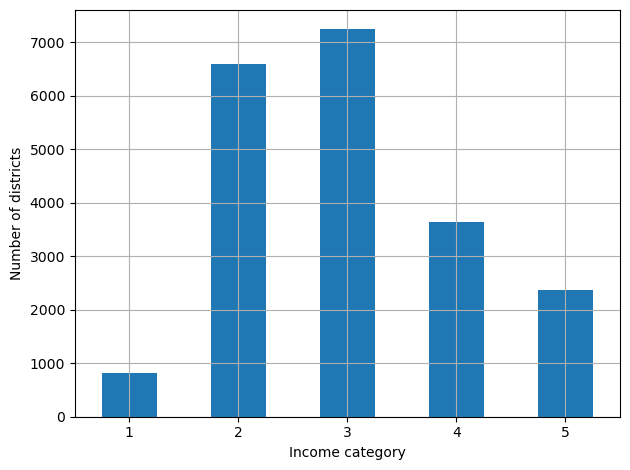

In [4]:
#
# pandas.cut은 value를 discrete interval로 bin 한다. value를 category화 한다고 볼 수도 있다
#

# input_dataframe에 income_cat column을 만든다
input_dataframe["income_cat"] = pandas.cut(input_dataframe["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., numpy.inf],
                               labels=[1, 2, 3, 4, 5])

# value_counts는 Series를 리턴
stat = input_dataframe['income_cat'].value_counts().sort_index()

for k in stat.index:
    print(f'{k}: {stat[k]}')
    
input_dataframe["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)

matplotlib.pyplot.xlabel("Income category")
matplotlib.pyplot.ylabel("Number of districts")
matplotlib_to_imagefile(output_dir, "housing_income_cat_bar_plot")  # extra code
matplotlib.pyplot.show()

In [5]:
#
# 우리의 sample이 income category의 비율을 맞춰서 sampling할 수 있도록 scikit-learn의 StratifiedShuffleSplit을 사용한다
#
strat_splitter = sklearn.model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []

for train_index, test_index in strat_splitter.split(input_dataframe, input_dataframe['income_cat']):
    # train_index, test_index에는 index의 list가 들어가 있다
    # input_dataframe.ilog[[3,6,9]] 이렇게 하면 input_dataframe의 row 3,6,9를 이어 만든 DataFrame이 리턴된다
    s_train, s_test = input_dataframe.iloc[train_index], input_dataframe.iloc[test_index]
    strat_splits.append([s_train, s_test])

# n_splits = 10 을 주었기 때문에 10이 나온다
print(len(strat_splits))

10


In [6]:
# 1개의 split만 있다면 훨씬 간단한 방법으로 얻을 수 있다

s_train, s_test = sklearn.model_selection.train_test_split(input_dataframe, test_size = 0.2, stratify = input_dataframe['income_cat'], random_state = 42)

In [7]:
#
# Random vs Stratified
#

r_train, r_test = sklearn.model_selection.train_test_split(input_dataframe, test_size = 0.2)
s_train, s_test = sklearn.model_selection.train_test_split(input_dataframe, test_size = 0.2, stratify = input_dataframe['income_cat'])

cmperr = pandas.DataFrame({
    'Overall %'    : input_dataframe['income_cat'].value_counts() / len(input_dataframe),
    'Stratified %' : s_train['income_cat'].value_counts() / len(s_train),
    'Random %'     : r_train['income_cat'].value_counts() / len(r_train),
}).sort_index()

cmperr.index.name = 'Income Category'
cmperr['Strat. Error %'] = (cmperr['Stratified %'] / cmperr['Overall %'] - 1)
cmperr['Rand. Error %']  = (cmperr['Random %']     / cmperr['Overall %'] - 1)
cmperr = (cmperr * 100).round(2)

cmperr

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,3.98,3.95,-0.09,-0.70
2,31.88,31.89,31.66,0.00,-0.70
3,35.06,35.06,35.13,0.00,0.19
4,17.63,17.63,17.53,-0.01,-0.56
5,11.44,11.45,11.72,0.02,2.46


In [8]:
#
# Stratified sampling을 했으면 이젠 income_cat은 필요없다
# 남겨놔 봐야 learning에 혼선만 줄 수 있으니 지워 버리자
# inplace가 False라면 적용된 copy를 리턴함. 아니면 None을 리턴하고 in-place 적용
#
s_train.drop('income_cat', axis=1, inplace=True)
s_test.drop('income_cat', axis=1, inplace=True)

# 여기서 부터는 이것을 사용한다
train = s_train.copy()
test = s_test.copy()